In [136]:
import time
from math import cos, pi, exp, e
import numpy
from numba import njit, jit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [137]:
y = 5
n_args_count = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max = 500  # больше 500 не нужно
number_of_agents = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight = 100  # максимальный вес рыбы

##Реализация алгоритма

In [138]:
@njit()
# @jit(nopython=True)
def main_function():
    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента
    # step_ind.append(float(input("Введите макс размер шага индивидуального перемещения: ")))
    # step_vol.append(float(input("Введите макс размер шага коллективно-волевого перемещения: ")))
    # step_ind.append(0.05)
    # step_vol.append(0.05)
    # w.append(numpy.zeros(number_of_agents) + max_weight / 2)

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents()  # Случано сгенерированное текущее поколение

    # P.append(generate_agents())  # Случано сгенерированное текущее поколение
    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    # p_qbest_list.append(p_qbest)
    p_qbest_list[t] = p_qbest

    # f_t = list()
    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t
    # F = [numpy.array(f_t)]

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        # step_ind.append(step_ind[0] * exp(-y * t / iter_max))
        # step_vol.append(step_vol[0] * exp(-y * t / iter_max))
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        # P.append(numpy.copy(P[t - 1]))
        # w.append(numpy.copy(w[t - 1]))
        # F.append(numpy.zeros(number_of_agents))
        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        delta_F = numpy.zeros(number_of_agents)
        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        for i in range(number_of_agents):
            delta_F[i] = F[t][i] - F[t - 1][i]
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = 0
            for i in range(number_of_agents):
                s += P_mul_F[i][j]
            I_t[j] = s
        I_t /= sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = 0
        for i in range(number_of_agents):
            sm2 += w[t][i]
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if sum(w[t]) > sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        # p_qbest_list.append(p_qbest)
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [139]:
def draw_graphic(f_val, functon_name):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [140]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [141]:
def start_test(function_name):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function()
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [142]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i ** 2 - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [143]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-5.12, 5.12, n_args_count)
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.00528134 0.00195073]
The function value of pqbest:		0.006288094979993275
Algorithm running time:			3.955915927886963 s


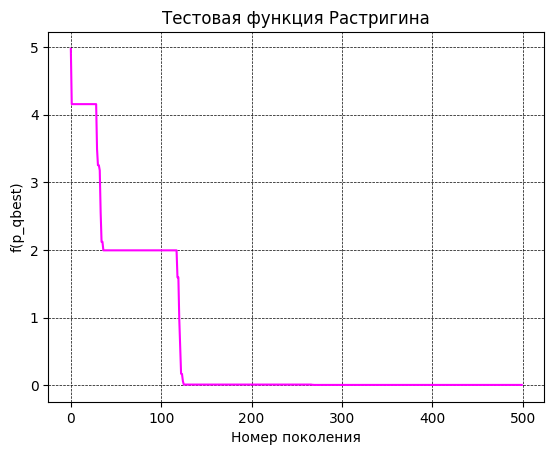

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.04207404 -0.96034186]
The function value of pqbest:		1.5802737735215828
Algorithm running time:			0.03198719024658203 s


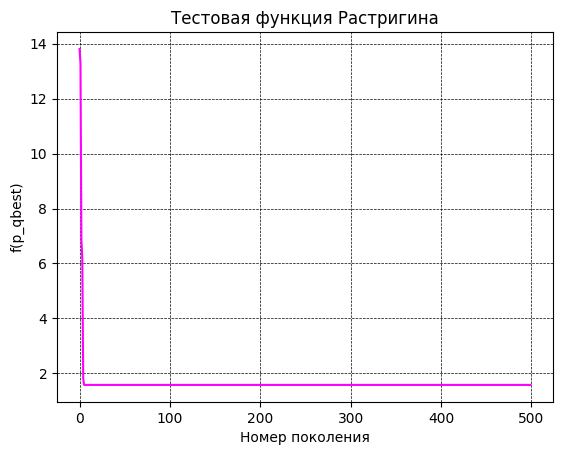

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.97969872 1.04833656]
The function value of pqbest:		2.59771968600408
Algorithm running time:			0.05001688003540039 s


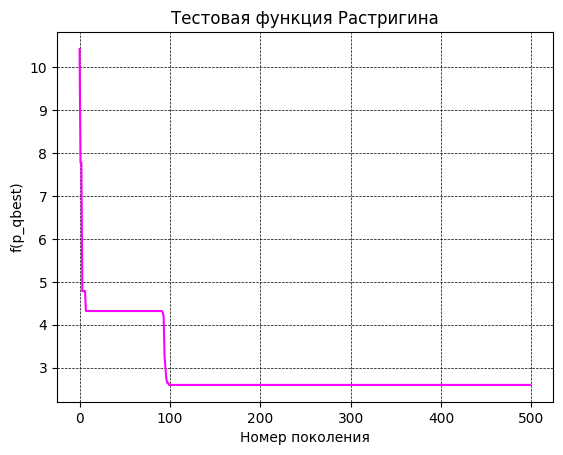

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-1.01803811  0.08793845]
The function value of pqbest:		2.596316916776722
Algorithm running time:			0.03200554847717285 s


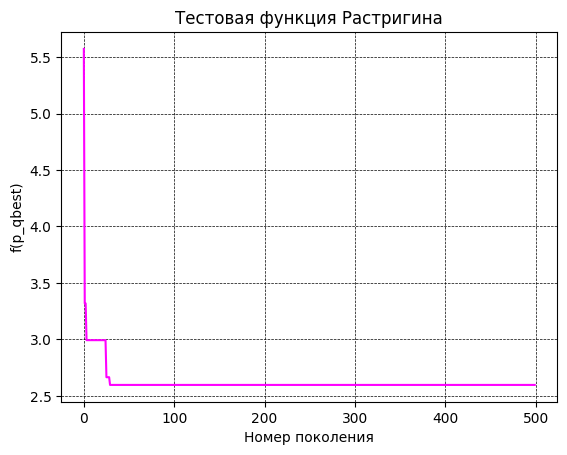

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.99763995 -0.0792228 ]
The function value of pqbest:		2.2161735881839846
Algorithm running time:			0.03200483322143555 s


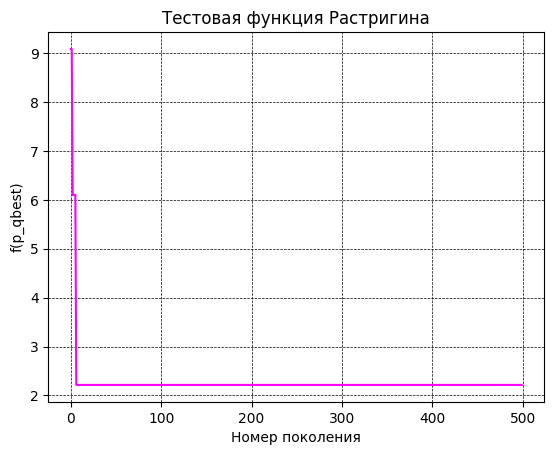

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.00954258 -0.87256597]
The function value of pqbest:		3.817327766768095
Algorithm running time:			0.040019989013671875 s


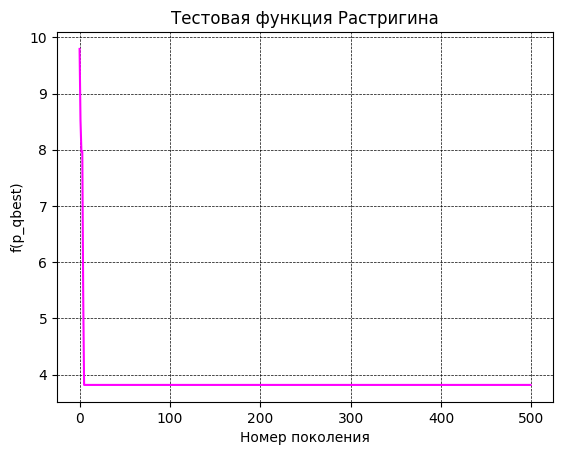

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.97785035 -0.03227556]
The function value of pqbest:		1.258840759604638
Algorithm running time:			0.031986236572265625 s


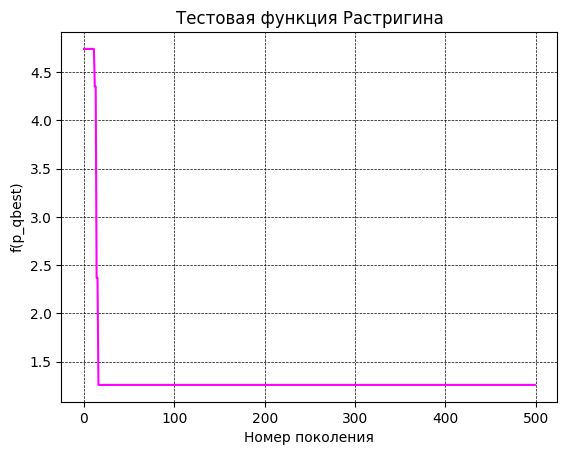

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 1.02317452 -0.97083653]
The function value of pqbest:		2.2626479715763743
Algorithm running time:			0.0320124626159668 s


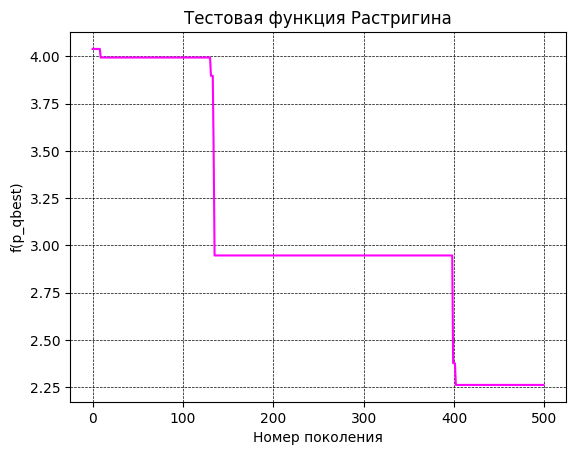

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.01401093  1.00461169]
The function value of pqbest:		1.0523630134844808
Algorithm running time:			0.024001359939575195 s


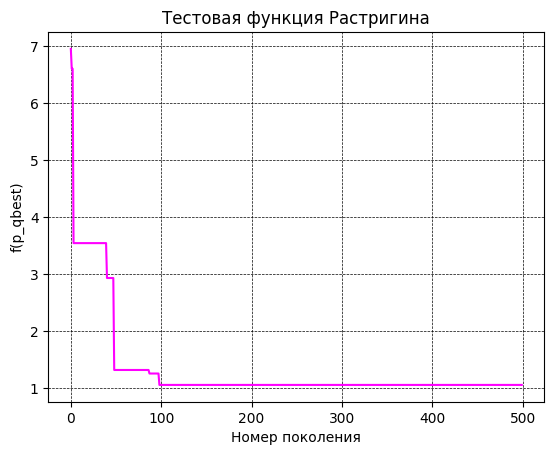

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[0.03006611 0.97723715]
The function value of pqbest:		1.2359070424925207
Algorithm running time:			0.03200244903564453 s


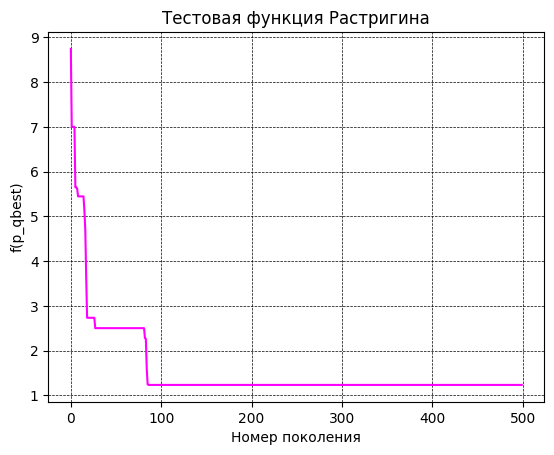

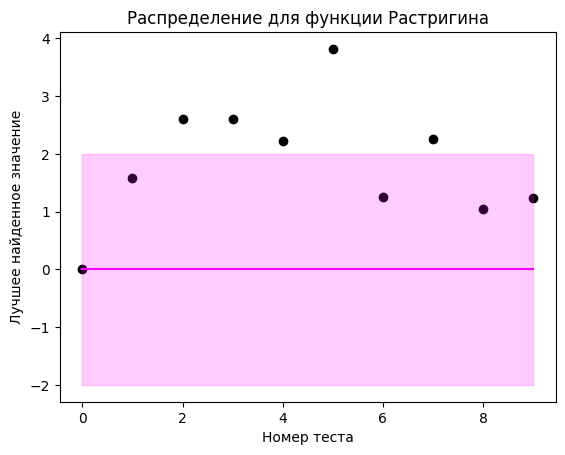

In [144]:
start_test("Растригина")

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [145]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * (0.5 * (x[0] ** 2 + x[1] ** 2)) ** 0.5) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [146]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-5, 5, n_args_count)
    # return result
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.01130154 -0.98935996]
The function value of pqbest:		2.6179979947227707
Algorithm running time:			0.04000687599182129 s


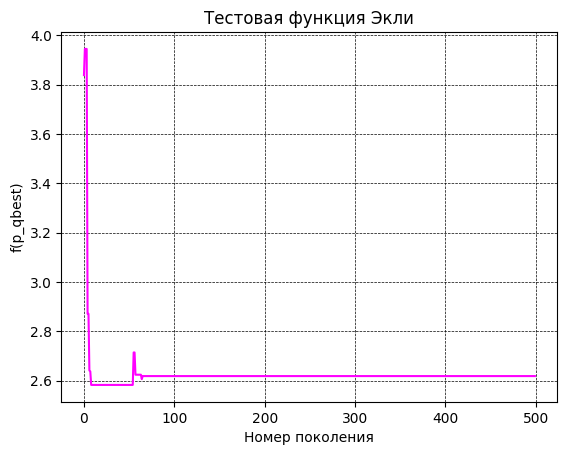

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.97394458  0.89463789]
The function value of pqbest:		3.7003257831497223
Algorithm running time:			0.03951120376586914 s


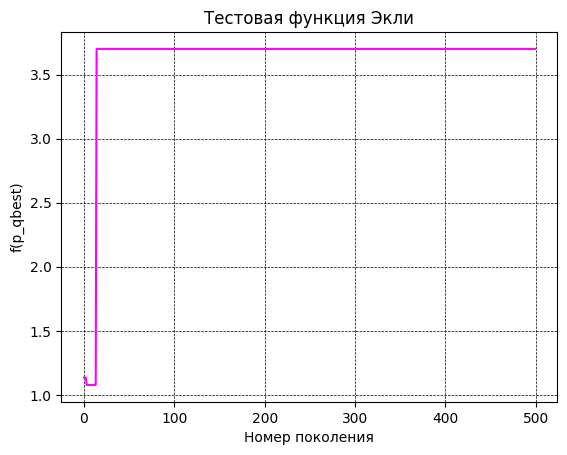

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.09001244 -0.08639276]
The function value of pqbest:		0.7277922323402599
Algorithm running time:			0.024006366729736328 s


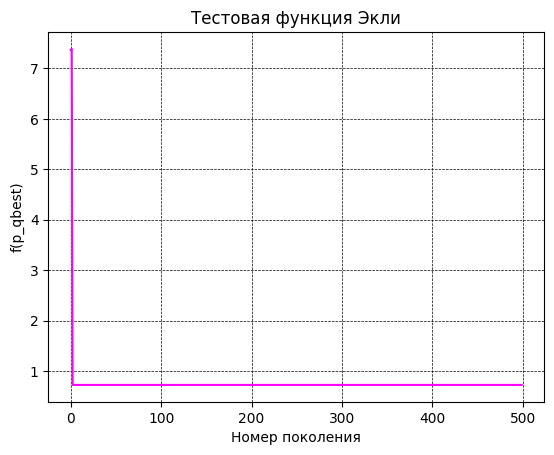

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.0028034 -1.0183826]
The function value of pqbest:		2.6918698279613587
Algorithm running time:			0.024016141891479492 s


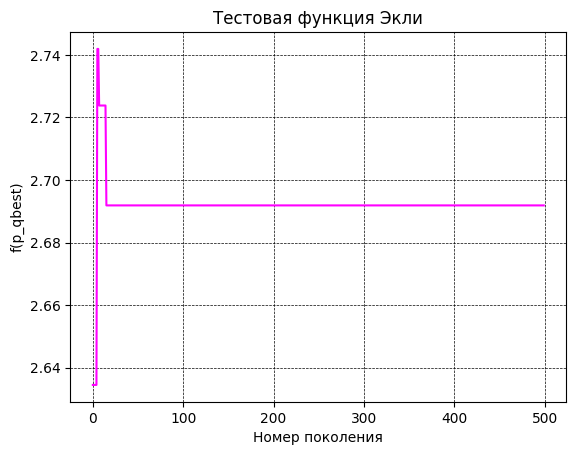

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.04955852  0.05004731]
The function value of pqbest:		0.3270781545317263
Algorithm running time:			0.024007081985473633 s


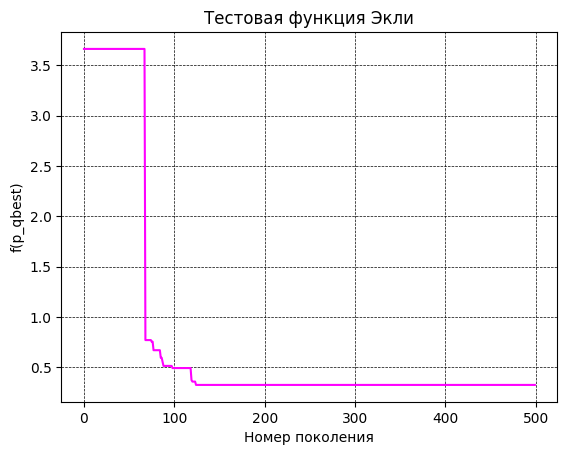

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.00206583 -1.00716151]
The function value of pqbest:		2.656601737879214
Algorithm running time:			0.03200030326843262 s


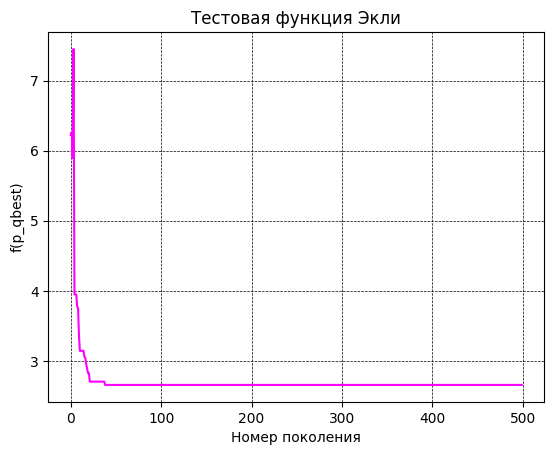

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.00755892 -0.02596249]
The function value of pqbest:		0.09584190939771631
Algorithm running time:			0.0240170955657959 s


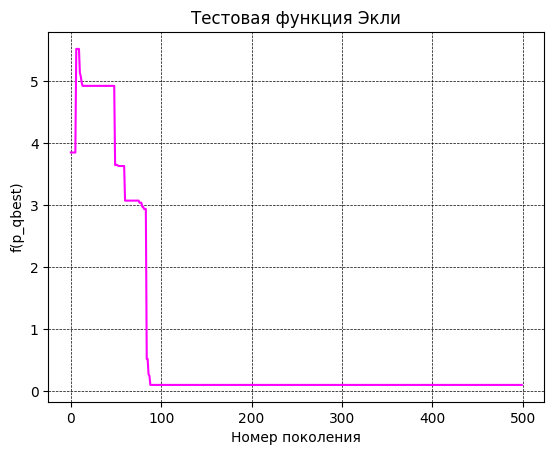

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-1.00367698  0.04391344]
The function value of pqbest:		2.7001946110095147
Algorithm running time:			0.03201794624328613 s


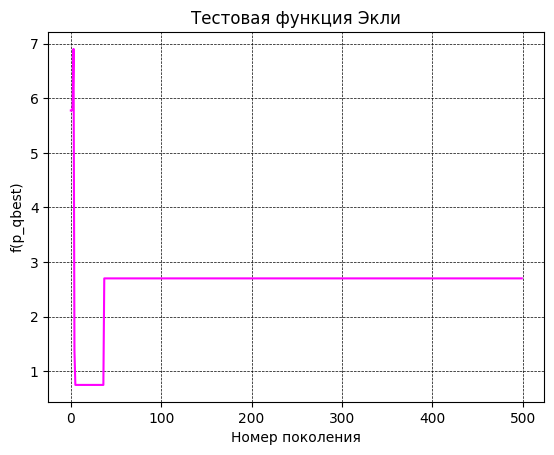

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.07173406  0.03294438]
The function value of pqbest:		0.38187929508193363
Algorithm running time:			0.04801607131958008 s


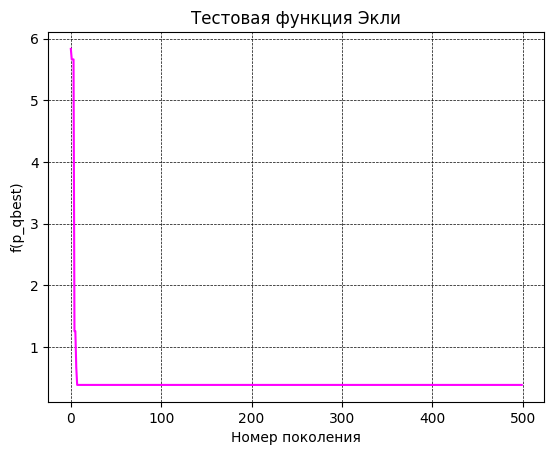

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.08860369 -0.04526999]
The function value of pqbest:		0.527267697155331
Algorithm running time:			0.023827552795410156 s


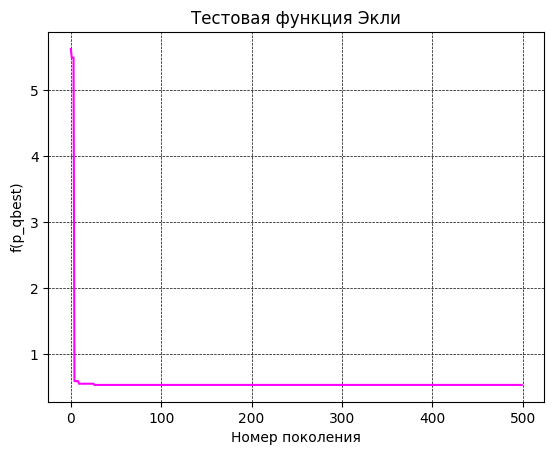

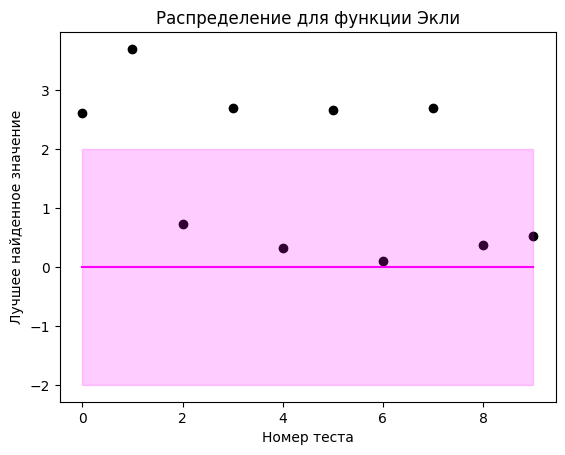

In [147]:
start_test("Экли")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [148]:
@njit()
# @jit(nopython=True)
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i ** 2
    return result

##Генерация начальных агентов

In [149]:
@njit()
# @jit(nopython=True)
def generate_agents():
    # result = numpy.zeros((number_of_agents, n_args_count))
    # for i in range(number_of_agents):
    #     result[i] = numpy.random.uniform(-10, 10, n_args_count)
    # return result
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.02653887 0.96941853]
The function value of pqbest:		0.9404765896443267
Algorithm running time:			0.02398061752319336 s


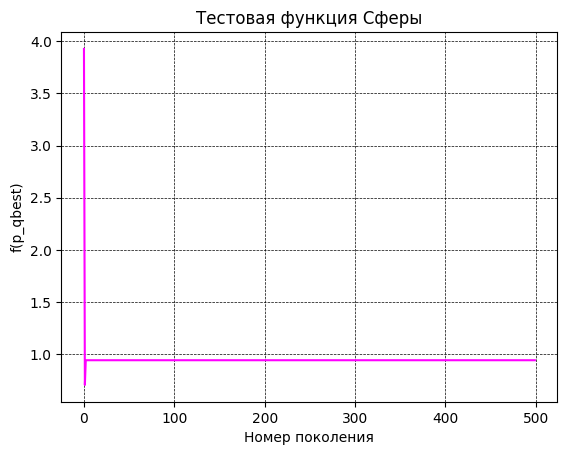

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 1.02244104 -0.98252265]
The function value of pqbest:		2.0107364289038347
Algorithm running time:			0.02510833740234375 s


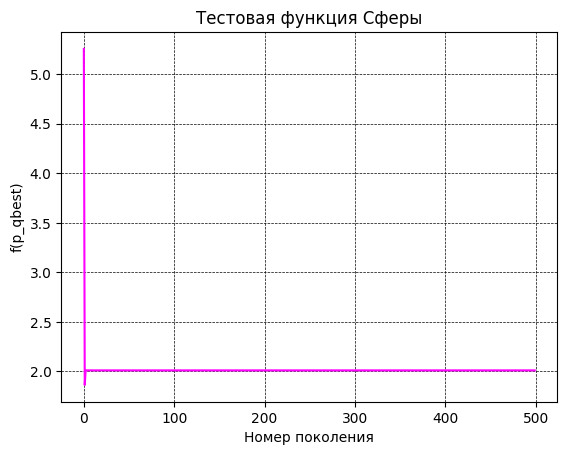

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.06556528 -0.12507442]
The function value of pqbest:		0.019942416371713206
Algorithm running time:			0.016518115997314453 s


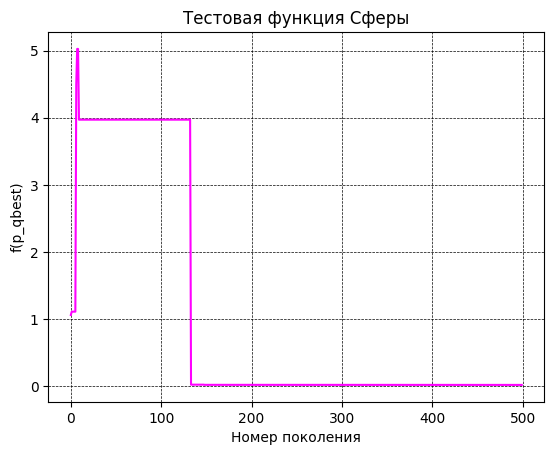

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.04512468  0.07843753]
The function value of pqbest:		0.008188683282867615
Algorithm running time:			0.01600193977355957 s


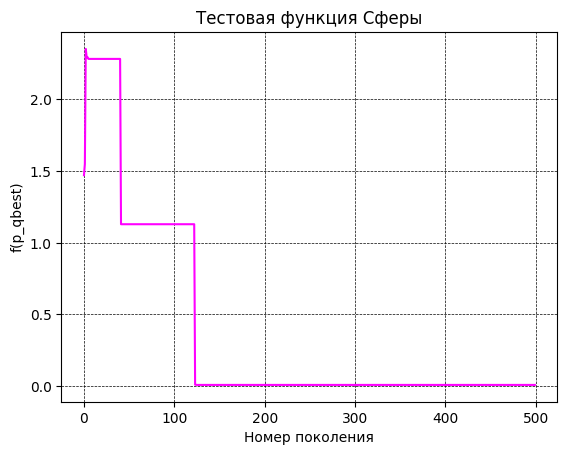

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.96519888 -0.00409276]
The function value of pqbest:		0.9316256325815011
Algorithm running time:			0.02389383316040039 s


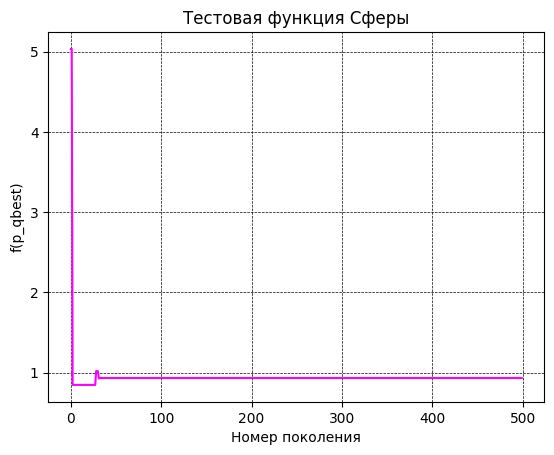

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.05100028  0.06356623]
The function value of pqbest:		0.006641693586415906
Algorithm running time:			0.01712632179260254 s


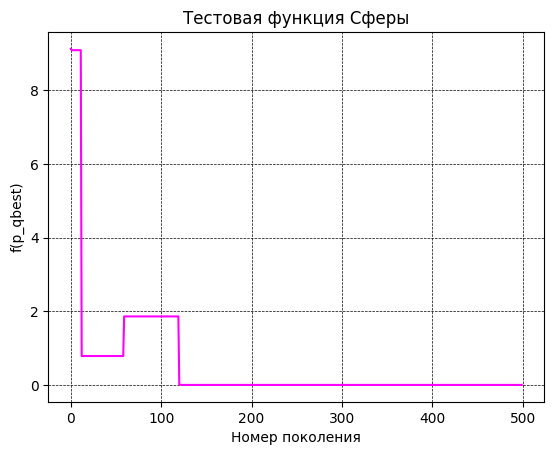

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 2.02028036 -0.03686186]
The function value of pqbest:		4.082891535589632
Algorithm running time:			0.016002178192138672 s


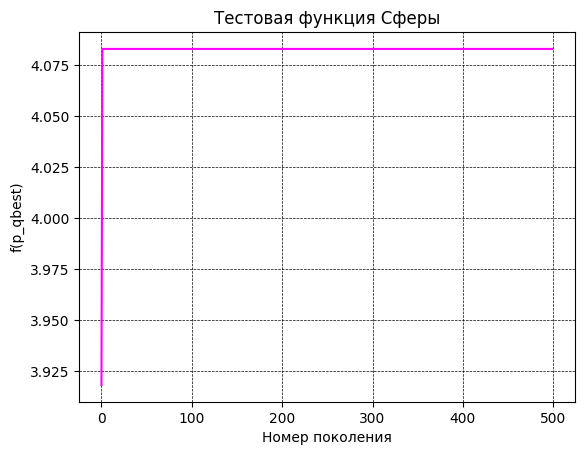

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.06277144 0.90349376]
The function value of pqbest:		0.820241230950664
Algorithm running time:			0.023665428161621094 s


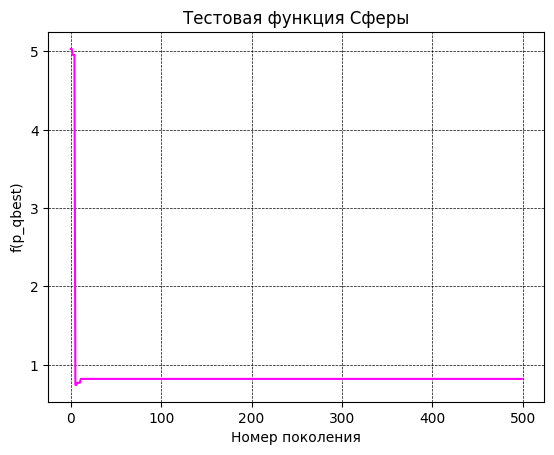

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.02195647 -0.04777872]
The function value of pqbest:		0.0027648929244120323
Algorithm running time:			0.02399897575378418 s


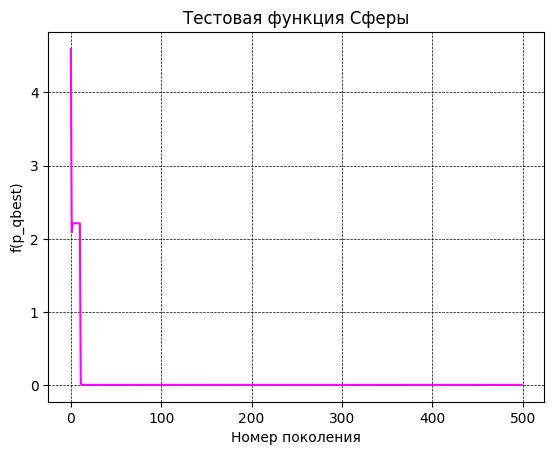

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.06013654  0.0389493 ]
The function value of pqbest:		0.005133451754239918
Algorithm running time:			0.02399420738220215 s


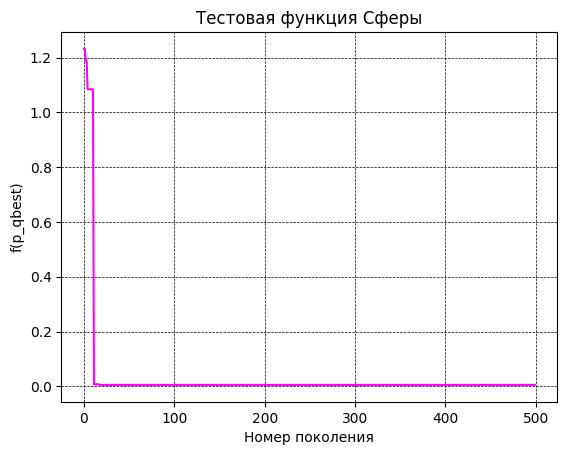

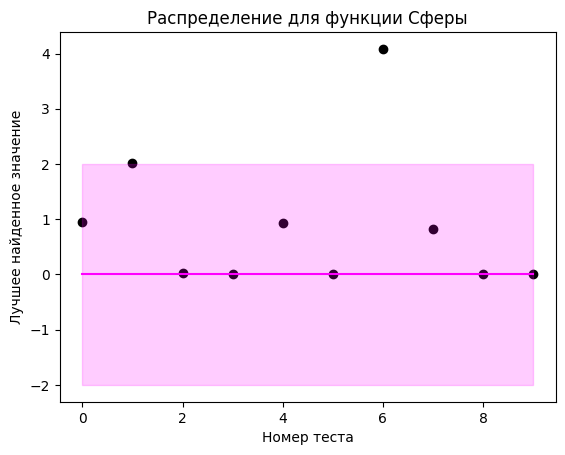

In [150]:
start_test("Сферы")
